# IMPORTANTE: Tienes que poner las cosas de este jupyter más bonitas
# Falta escribir el enunciado del problema
# Falta escribir tu nombre 
# No olvides las conclusiones 
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

## Se importan las librerías

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Instalar: pip install category_encoders
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# SOLUCIÓN INCISO a) 

## Se importa y se limpia la data  

### **Paso 1**: Cargar el archivo y reemplazar `"?"` por `NaN`

**Objetivo:**  
Cargar correctamente el dataset y reemplazar los valores faltantes representados por `"?"` con `NaN`, que es el formato estándar para valores nulos en pandas.

**Acción realizada:**
- Se utilizó el parámetro `na_values="?"` dentro de `pd.read_csv()` para que pandas detecte automáticamente los `"?"` como `NaN`.
- También se asignaron manualmente los nombres de las columnas utilizando el argumento `names=`, ya que el archivo no contiene encabezados (`header=None`).

**Ventajas:**
- Facilita el tratamiento de valores faltantes en etapas posteriores.
- Tener nombres de columnas descriptivos mejora la legibilidad del código y facilita el análisis posterior.

In [3]:
# Leer el archivo CSV y reemplazar los "?" por valores nulos (NaN)

# Nombre de las columnas.
# Se consultaron en la documentación oficial del DataSet
column_names = [
    "symboling", "normalized-losses", "make", "fuel-type", "aspiration",
    "num-of-doors", "body-style", "drive-wheels", "engine-location",
    "wheel-base", "length", "width", "height", "curb-weight", "engine-type",
    "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke",
    "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"
]

ruta = "data_carros.csv"
data = pd.read_csv(ruta,
                   na_values="?", # los valores con "?" se transforman a NaN
                   names=column_names # cambiamos el nombre a las columnas
                  )

# OPCIONAL: 
#print(data.columns.tolist())

# Verificar rápidamente cuántos valores faltantes hay por columna
#print(data.isna().sum())

### **Paso 2**: Conversión de columnas numéricas con valores faltantes a tipo `float`

**Objetivo:**  
Convertir las columnas numéricas con valores faltantes a tipo `float`, para poder realizar imputaciones, análisis estadístico y entrenar modelos de regresión correctamente.

**Columnas convertidas:**
- `normalized-losses`
- `bore`
- `stroke`
- `horsepower`
- `peak-rpm`
- `price`

**¿Por qué es hacerlo?**
- Estas columnas pueden contener valores faltantes (`NaN`) provenientes de caracteres `"?"`.
- Si no se convierten, pandas las trata como tipo `object` (texto), lo cual impide hacer cálculos como la media o entrenar modelos de regresión.
- La conversión a `float` permite manipular estos datos numéricamente sin errores.

In [4]:
# Lista de columnas numéricas que pueden tener valores faltantes y deben convertirse a float
# No se consideran las variables categóricas
# Nuevamente, la información se obtuvo del sitio oficial
cols_to_numeric = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']

# Convertir a tipo numérico (float), forzando errores a NaN por si quedara algún valor extraño
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Confirmar los tipos de datos después de la conversión
print(data.dtypes[cols_to_numeric])

normalized-losses    float64
bore                 float64
stroke               float64
horsepower           float64
peak-rpm             float64
price                float64
dtype: object


### **Paso 3**: Eliminar las filas donde `price` está ausente

**Objetivo:**  
Eliminar las filas que no tienen valor en la columna `price`, ya que esta es la **variable objetivo** (target) que queremos predecir mediante regresión.

**¿Por qué no imputar `price`?**
- `price` es la salida del modelo, y estimarla artificialmente introduciría **error o sesgo** en el entrenamiento.
- Solo hay **4 filas faltantes**, por lo que eliminarlas no afecta significativamente el tamaño del conjunto de datos (o al menos, esto es lo que se espera).

In [5]:
# Eliminar filas donde 'price' sea NaN (nuestra variable objetivo)
data = data.dropna(subset=["price"])

# Reiniciar los índices después de eliminar filas
data = data.reset_index(drop=True)

# Verificar cuántos valores faltantes quedan en 'price' (debe ser 0)
print("Valores faltantes en 'price':", data["price"].isna().sum())

Valores faltantes en 'price': 0


### **Paso 4**: Imputar valores faltantes en otras columnas

**Objetivo:**  
Llenar los valores faltantes en las columnas **predictoras** (features), ya que la mayoría de los modelos de regresión no funcionan con datos incompletos.

---

#### Tipos de imputación aplicados:

- **Para columnas numéricas:**  
  Se utilizó la **media** de la columna (`mean()`), ya que es una técnica simple y efectiva cuando los datos están distribuidos aproximadamente de forma normal.

- **Para columnas categóricas:**  
  Se utilizó la **moda** (`mode()`), que representa el valor más frecuente, ideal para variables como `"num-of-doors"`.

---

#### Columnas con imputación:

- **Numéricas:**
  - `normalized-losses`
  - `bore`
  - `stroke`
  - `horsepower`
  - `peak-rpm`

- **Categórica:**
  - `num-of-doors`


In [6]:
# Imputar columnas numéricas con la media
cols_numericas = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']
for col in cols_numericas:
    data[col] = data[col].fillna(data[col].mean())

# Imputar columnas categóricas con la moda
data['num-of-doors'] = data['num-of-doors'].fillna(data['num-of-doors'].mode()[0])

# Verificar que ya no haya valores nulos
print(data.isna().sum())

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64


### Paso 5: Codificación de variables categóricas

**Objetivo:**  
Transformar las variables categóricas en representaciones numéricas para que puedan ser utilizadas por algoritmos de regresión, ya que estos no trabajan directamente con texto.

---

#### 1. **Ordinal Encoding (Mapping)**

Convierte variables categóricas con un **orden lógico** en valores numéricos enteros que reflejan ese orden.

**Aplicado a:**
- `num-of-doors`: `"two"` → 2, `"four"` → 4
- `num-of-cylinders`: `"four"` → 4, `"six"` → 6, etc.

Se usa porque estas variables tienen un significado numérico implícito que conviene conservar.

---

#### 2. **One-Hot Encoding**

Convierte cada categoría en una nueva columna binaria (`True` / `False`), **sin asumir ningún orden entre ellas**.

**Aplicado a variables con pocas categorías:**
- `fuel-type`
- `aspiration`
- `body-style`
- `drive-wheels`
- `engine-location`
- `engine-type`

Se usa cuando hay pocas clases distintas y no hay una jerarquía clara entre ellas.

---

#### 3. **Target Encoding (manual)**

Reemplaza cada categoría por el **promedio del valor objetivo (`price`)** para esa categoría.

**Aplicado a:**
- `make` (22 marcas distintas)
- `fuel-system` (8 categorías, algunas poco frecuentes)

Se utiliza cuando hay **muchas categorías** y One-Hot Encoding generaría demasiadas columnas. Target Encoding captura el efecto promedio de cada categoría sobre la variable objetivo, y es útil en modelos de regresión.

*Nota:* Esta técnica puede causar overfitting si no se aplica con regularización o validación cruzada. Para este análisis exploratorio se usó de forma directa con `groupby().mean()` y `.map()`.

---

#### 4. **Conversión de booleanos a enteros (0/1)**

Después de aplicar One-Hot Encoding, las nuevas columnas generadas por pandas tienen valores `True` o `False`.  
Aunque los modelos de regresión pueden trabajar con ellos, se optó por convertirlos a enteros para:

- Asegurar consistencia en el tipo de datos (`int` en lugar de `bool`)
- Facilitar análisis, visualización o exportación posterior

**Aplicado a:**  
Todas las columnas generadas por One-Hot Encoding (`*_gas`, `*_turbo`, etc.)

---

#### Resumen de codificación por variable:

| Variable            | Codificación         |
|---------------------|----------------------|
| `num-of-doors`      | Ordinal Mapping      |
| `num-of-cylinders`  | Ordinal Mapping      |
| `fuel-type`         | One-Hot              |
| `aspiration`        | One-Hot              |
| `body-style`        | One-Hot              |
| `drive-wheels`      | One-Hot              |
| `engine-location`   | One-Hot              |
| `engine-type`       | One-Hot              |
| `make`              | Target Encoding      |
| `fuel-system`       | Target Encoding      |
| One-Hot dummies     | Conversión a enteros |


In [7]:
# Lista con las variables categóricas que contiene el DataSet
columnas_categoricas = [
    "make",
    "fuel-type",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "engine-type",
    "num-of-cylinders",
    "fuel-system"
]

# Esta línea es para saber el tipo de elementos con los cuales se está trabajando 
# for categoria in columnas_categoricas:
#     print(10*"---")
#     print(data[categoria].value_counts())

In [8]:
# ✅ 1. Imputación y Ordinal Encoding: convertir texto a números donde el orden tiene sentido

# Imputar num-of-doors de forma segura
if not data["num-of-doors"].mode().empty:
    moda_puertas = data["num-of-doors"].mode()[0]
else:
    moda_puertas = "four"
data["num-of-doors"] = data["num-of-doors"].fillna(moda_puertas)

# Imputar num-of-cylinders de forma segura
if not data["num-of-cylinders"].mode().empty:
    moda_cilindros = data["num-of-cylinders"].mode()[0]
else:
    moda_cilindros = "four"
data["num-of-cylinders"] = data["num-of-cylinders"].fillna(moda_cilindros)

# Mapeo ordinal
data["num-of-doors"] = data["num-of-doors"].map({
    "two": 2,
    "four": 4
})

data["num-of-cylinders"] = data["num-of-cylinders"].map({
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "eight": 8,
    "twelve": 12
})

# ✅ 2. Target Encoding manual para columnas con muchas categorías

mean_price_by_make = data.groupby("make")["price"].mean()
data["make_encoded"] = data["make"].map(mean_price_by_make)

mean_price_by_fuel = data.groupby("fuel-system")["price"].mean()
data["fuel-system_encoded"] = data["fuel-system"].map(mean_price_by_fuel)

# Eliminar columnas originales
data = data.drop(columns=["make", "fuel-system"])

# ✅ 3. One-Hot Encoding para columnas con pocas clases
categoricas_one_hot = [
    "fuel-type",
    "aspiration",
    "body-style",
    "drive-wheels",
    "engine-location",
    "engine-type"
]

data = pd.get_dummies(data, columns=categoricas_one_hot, drop_first=True)

# ✅ 5.5 Conversión de columnas booleanas a enteros (0/1) para claridad
bool_cols = data.select_dtypes(include=["bool"]).columns
data[bool_cols] = data[bool_cols].astype(int)

# ✅ Verificación final
print("Tipos de datos por columna:")
print(data.dtypes)

print("\n¿Hay valores nulos?")
print(data.isna().sum().sum() == 0)  # True si no hay NaN

Tipos de datos por columna:
symboling                 int64
normalized-losses       float64
num-of-doors              int64
wheel-base              float64
length                  float64
width                   float64
height                  float64
curb-weight               int64
num-of-cylinders          int64
engine-size               int64
bore                    float64
stroke                  float64
compression-ratio       float64
horsepower              float64
peak-rpm                float64
city-mpg                  int64
highway-mpg               int64
price                   float64
make_encoded            float64
fuel-system_encoded     float64
fuel-type_gas             int64
aspiration_turbo          int64
body-style_hardtop        int64
body-style_hatchback      int64
body-style_sedan          int64
body-style_wagon          int64
drive-wheels_fwd          int64
drive-wheels_rwd          int64
engine-location_rear      int64
engine-type_l             int64
engine-type_

## Entrenamiento

### Se parte la data

In [10]:
# Separar variables predictoras (X) y variable objetivo (y)
X = data.drop(columns="price").values  # Convertimos a numpy array
y = data["price"].values

### 📐 ¿Qué hace `PolynomialFeatures` desde el punto de vista matemático?

La clase `PolynomialFeatures(degree=d)` transforma las variables originales en una nueva matriz de características que contiene **todos los monomios posibles** hasta el grado `d`. Esto permite capturar relaciones **no lineales** usando modelos lineales.

---

#### 🧮 Definición formal

Dado un vector de entrada:

$$
\mathbf{x} = [x_1, x_2, \dots, x_n]
$$

`PolynomialFeatures(degree=d)` genera todos los términos del tipo:

$$
x_1^{a_1} x_2^{a_2} \dots x_n^{a_n} \quad \text{tales que} \quad a_1 + a_2 + \dots + a_n \leq d
$$

Cada uno de estos términos se convierte en una nueva columna en la matriz de entrada transformada.

---

#### 🔹 Ejemplo con dos variables:

Si se tiene $$ \mathbf{x} = [x_1, x_2] $$

- Grado 1:  
  $$
  [x_1, x_2]
  $$

- Grado 2:  
  $$
  [x_1, x_2, x_1^2, x_1 x_2, x_2^2]
  $$

- Grado 3:  
  $$
  [x_1, x_2, x_1^2, x_1 x_2, x_2^2, x_1^3, x_1^2 x_2, x_1 x_2^2, x_2^3]
  $$

---

#### ⚠️ Nota:

- Si `include_bias=True`, se incluye el término constante \( 1 \).
- En nuestro caso usamos `include_bias=False` para evitar duplicar el intercepto del modelo.

---

#### 🧠 ¿Qué hace `.fit_transform(X)`?

La instrucción `poly.fit_transform(X)` aplica la transformación polinomial a **todas las filas** de la matriz `X`.

- Por cada fila (ejemplo), calcula todas las combinaciones de los atributos hasta el grado `d`
- Devuelve una **nueva matriz `X_poly`**, con el mismo número de filas, pero con muchas más columnas

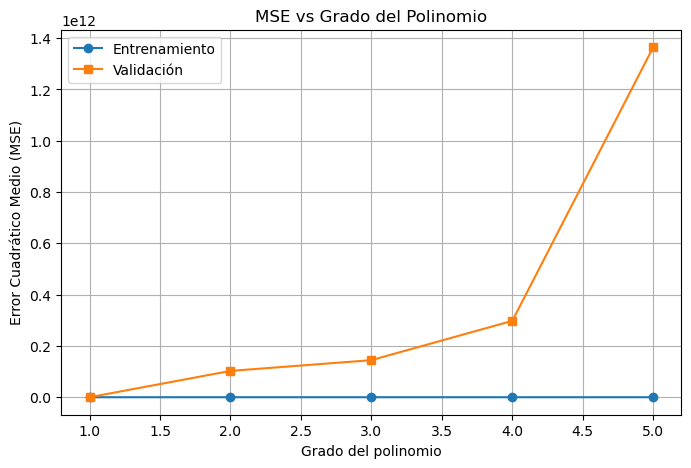

In [18]:
# Lista de grados de polinomio a evaluar
grados = [1, 2, 3, 4, 5]

# Listas para almacenar el MSE promedio de entrenamiento y validación por cada grado
mse_ent = []
mse_val = []

# Configurar validación cruzada: 5 folds repetidos 10 veces (total 50 combinaciones train/val)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Recorremos cada grado de polinomio
for grado in grados:
    
    # Crear el transformador polinomial para ese grado
    poly = PolynomialFeatures(degree=grado, include_bias=True)
    
    # Aplicar la transformación a toda la matriz X (genera nuevas columnas no lineales)
    X_poly = poly.fit_transform(X)

    # Inicializar listas para los errores de cada fold
    mse_train_fold = []  # MSE de entrenamiento por fold
    mse_val_fold = []    # MSE de validación por fold

    # Recorrer cada fold de la validación cruzada
    for train_idx, val_idx in cv.split(X_poly):
        # Dividir los datos en entrenamiento y validación
        X_train, X_val = X_poly[train_idx], X_poly[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Crear y entrenar el modelo de regresión lineal (mínimos cuadrados)
        modelo = LinearRegression()
        modelo.fit(X_train, y_train)

        # Generar predicciones sobre entrenamiento y validación
        y_train_pred = modelo.predict(X_train)
        y_val_pred = modelo.predict(X_val)

        # Calcular y guardar el error cuadrático medio para ambos conjuntos
        mse_train_fold.append(mean_squared_error(y_train, y_train_pred))
        mse_val_fold.append(mean_squared_error(y_val, y_val_pred))

    # Calcular el promedio de MSE en los 50 folds y almacenarlos
    mse_ent.append(np.mean(mse_train_fold))
    mse_val.append(np.mean(mse_val_fold))

# -------------------------
# Visualización de resultados
# -------------------------

# Crear la figura
plt.figure(figsize=(8,5))

# Graficar MSE en entrenamiento vs grado
plt.plot(grados, mse_ent, marker='o', label="Entrenamiento")

# Graficar MSE en validación vs grado
plt.plot(grados, mse_val, marker='s', label="Validación")

# Etiquetas y título
plt.xlabel("Grado del polinomio")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("MSE vs Grado del Polinomio")

# Leyenda y grilla
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()
plt.savefig("MSEvsGrado.png")

## Conclusiones

Hay que escribir algo chido, krnal 

# SOLUCIÓN INCISO b) 

## Mínimos cuadrados con penalización (Ridge y Lasso)

En esta parte se realiza la regresión utilizando un **polinomio de grado 20** sobre los atributos, pero ahora se agrega un **término de penalización** que limita el tamaño de los coeficientes para evitar el sobreajuste.

---

#### Objetivo

- Aplicar **regresión polinomial de grado 20**.
- Incorporar **penalización por norma L2 (Ridge, [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))** y **norma L1 (Lasso)**.
- Evaluar el desempeño para diferentes valores del parámetro de regularización $ \lambda $ (llamado `alpha` en `scikit-learn`).
- Comparar el **Error Cuadrático Medio (MSE)** en entrenamiento y validación.

---

#### ¿Qué es la regularización?

Cuando el modelo tiene **muchas variables** (como ocurre al expandir a grado 20), puede aprender demasiado bien los datos de entrenamiento y fallar al generalizar. Esto se llama **sobreajuste**.

La regularización **agrega un castigo al tamaño de los coeficientes** $ \beta $, controlado por un parámetro $ \lambda $:

$$
\min_{\beta} \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \|\beta\|_p
$$

- **Ridge (L2)**: penaliza con la **norma cuadrada**  
  $$ \|\beta\|_2^2 = \sum \beta_i^2 $$
  
- **Lasso (L1)**: penaliza con la **norma absoluta**  
  $$ \|\beta\|_1 = \sum |\beta_i| $$

---

#### Estrategia

1. Aplicar `PolynomialFeatures(degree=20)` para generar variables polinomiales.
2. Probar diferentes valores de `alpha`:
   $
   \lambda \in \{0.01, 0.1, 1, 10, 100\}
   $
3. Usar:
   - `Ridge(alpha=λ)` para penalización L2
   - `Lasso(alpha=λ)` para penalización L1
4. Evaluar con validación cruzada de 5 folds repetida 10 veces.
5. Graficar el MSE promedio en entrenamiento y validación para cada $ \lambda $.

---

#### ⚠️ Nota sobre Lasso

Dado que Lasso tiende a **reducir muchos coeficientes a cero**, es especialmente útil cuando queremos **seleccionar atributos relevantes** automáticamente.  
Sin embargo, puede necesitar ajustes finos y más cuidado numérico cuando se usan muchos atributos.

---

/home/danirm/anaconda3/envs/aprendizaje_automatizado/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/danirm/anaconda3/envs/aprendizaje_automatizado/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/danirm/anaconda3/envs/aprendizaje_automatizado/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/danirm/anaconda3/envs/aprendizaje_automatizado/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/danirm/anaconda3/envs/aprendizaje_automatizado/lib/python3.9/site-packages/sklearn/linear_

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

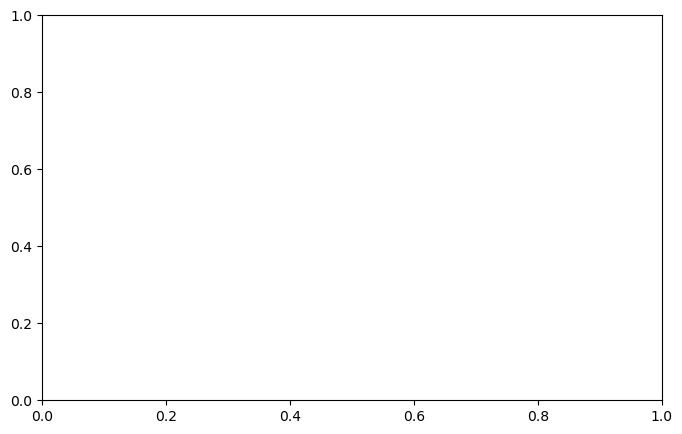

In [27]:
# Lista de grados de polinomio a evaluar
gradoo = 20
lambdas = [0.01] #Scikitlearn lo cataloga como alpha

# Listas para almacenar el MSE promedio de entrenamiento y validación por cada grado
mse_ent = []
mse_val = []

# Configurar validación cruzada: 5 folds repetidos 10 veces (total 50 combinaciones train/val)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Recorremos cada grado de polinomio
    
# Crear el transformador polinomial para ese grado
poly = PolynomialFeatures(degree=grado, include_bias=True)
    
# Aplicar la transformación a toda la matriz X (genera nuevas columnas no lineales)
X_poly = poly.fit_transform(X)

# Inicializar listas para los errores de cada fold
mse_train_fold = []  # MSE de entrenamiento por fold
mse_val_fold = []    # MSE de validación por fold

# Recorrer cada fold de la validación cruzada
for train_idx, val_idx in cv.split(X_poly):
    # Dividir los datos en entrenamiento y validación
    X_train, X_val = X_poly[train_idx], X_poly[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Crear y entrenar el modelo de regresión lineal (mínimos cuadrados)
    modelo = Ridge(lambdas[0])
    modelo.fit(X_train, y_train)

    # Generar predicciones sobre entrenamiento y validación
    y_train_pred = modelo.predict(X_train)
    y_val_pred = modelo.predict(X_val)

    # Calcular y guardar el error cuadrático medio para ambos conjuntos
    mse_train_fold.append(mean_squared_error(y_train, y_train_pred))
    mse_val_fold.append(mean_squared_error(y_val, y_val_pred))

# Calcular el promedio de MSE en los 50 folds y almacenarlos
mse_ent.append(np.mean(mse_train_fold))
mse_val.append(np.mean(mse_val_fold))

# -------------------------
# Visualización de resultados
# -------------------------

# Crear la figura
plt.figure(figsize=(8,5))

# Graficar MSE en entrenamiento vs grado
plt.plot(grados, mse_ent, marker='o', label="Entrenamiento")

# Graficar MSE en validación vs grado
plt.plot(grados, mse_val, marker='s', label="Validación")

# Etiquetas y título
plt.xlabel("Grado del polinomio")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("MSE vs Grado del Polinomio")

# Leyenda y grilla
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.savefig("MSEvsGrado.png", dpi=300, bbox_inches='tight')
plt.show()